In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

csv = pd.read_csv('database.csv', sep=',')
df = pd.DataFrame(csv)[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

# Перевод даты и времени в соответствующий формат, любые необработанные данные получают тип NaT (Not a Time)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')

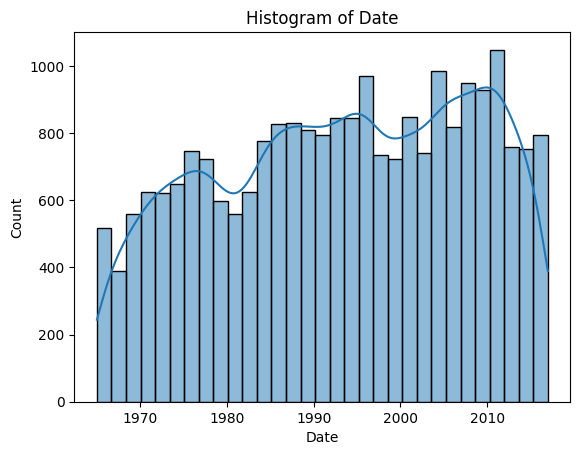

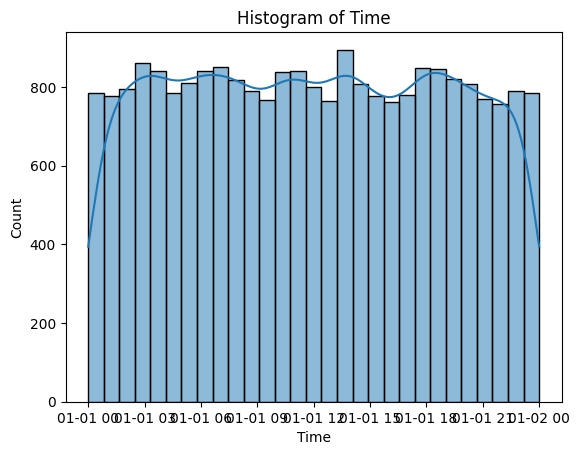

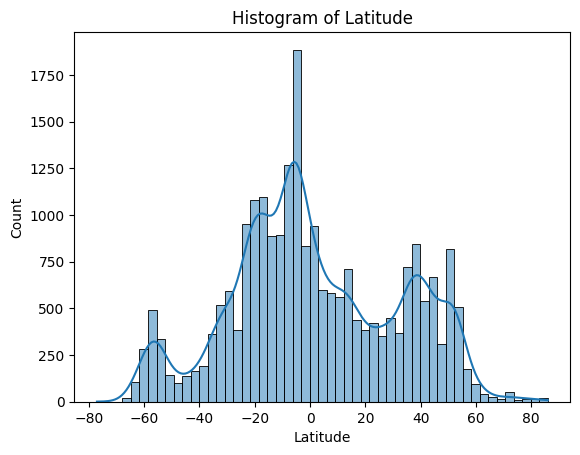

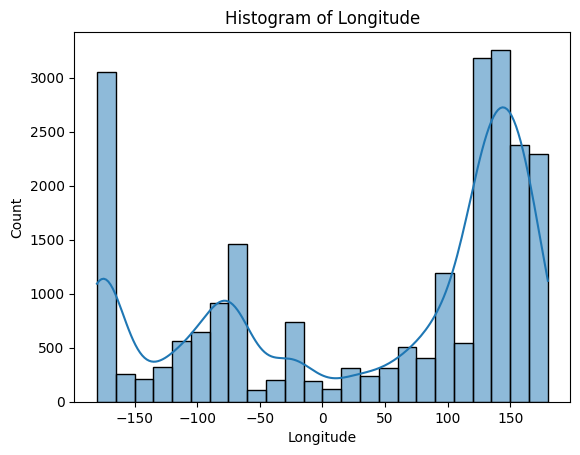

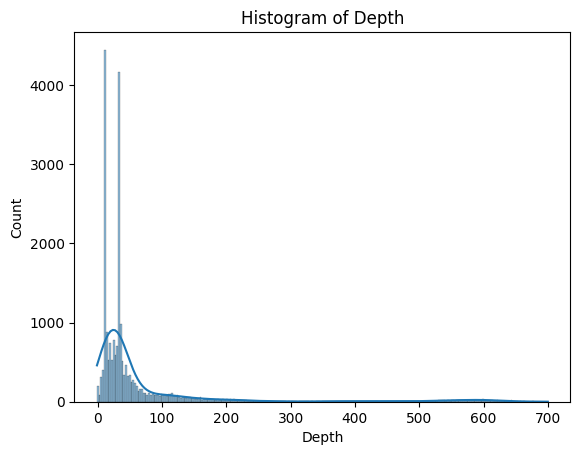

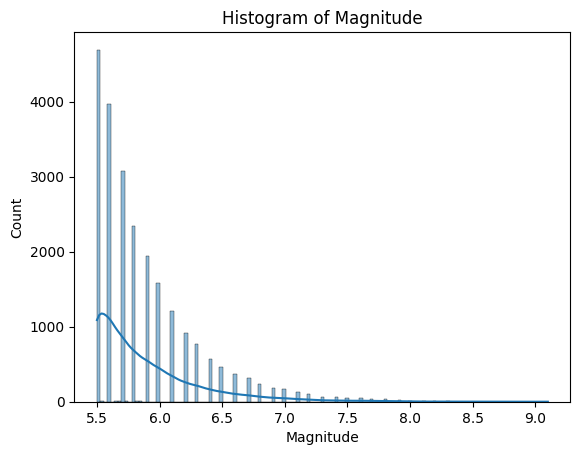

In [2]:
# Гистограммы распределения значений
for col in ['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']:
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.show()

In [3]:
# Поиск пропущенных значений
print('Пропущенные значения:')
for col in df.columns:
    num_missing = df[col].isnull().sum()
    if num_missing > 0:
        print(f'{col}: {num_missing}')

Пропущенные значения:
Date: 3
Time: 3


In [4]:
# Удалим строки с пропущенными значениями
df.dropna(inplace=True)

In [5]:
# Добавим к датасету атрибут "сейсмический момент землетрясения"
df['Moment'] = 10**((3/2)*(df['Magnitude'] + 10.7))
df.sample(5)

,Date,Time,Latitude,Longitude,Depth,Magnitude,Moment
12691,1995-10-04,1900-01-01 15:12:34,52.711,172.412,27.0,5.9,7.943282e+24
10308,1990-12-31,1900-01-01 17:57:03,0.857,126.689,70.5,5.5,1.995262e+24
12008,1994-07-16,1900-01-01 18:05:06,-4.619,125.615,442.7,5.7,3.981072e+24
3005,1974-01-30,1900-01-01 10:12:10,-4.920,134.203,33.0,5.6,2.818383e+24
18533,2007-07-23,1900-01-01 06:00:36,-4.109,-104.235,10.0,5.5,1.995262e+24


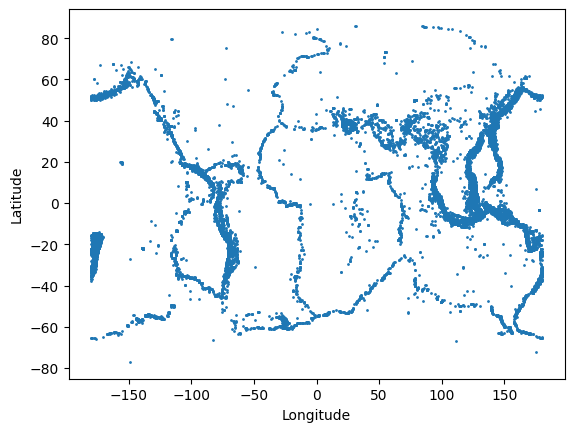

In [6]:
plt.scatter(df['Longitude'], df['Latitude'], s = 1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# На графике можно выделить два основных кластера: в районе островных государств Азии и вдоль западного побережья Южной Америки
# Объясняется это столкновением литосферных плит в этих районах

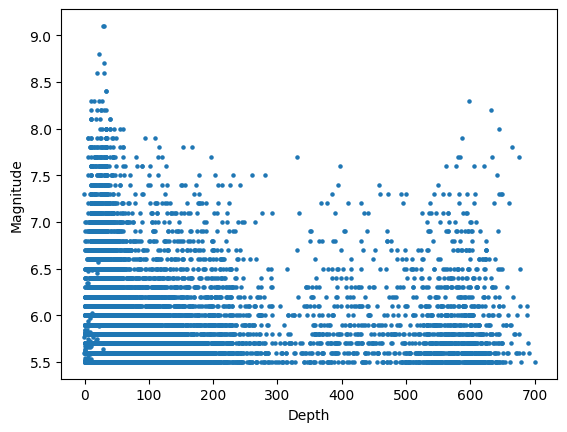

In [7]:
plt.scatter(df['Depth'], df['Magnitude'], s = 5)
plt.xlabel('Depth')
plt.ylabel('Magnitude')
plt.show()

# Вновь можно выделить две основные группы:
# землетрясения магнитудой до 6.5 и глубиной менее 150 метров
# землетрясения магнитудой до 6 и глубиной от 550 до 650 метров

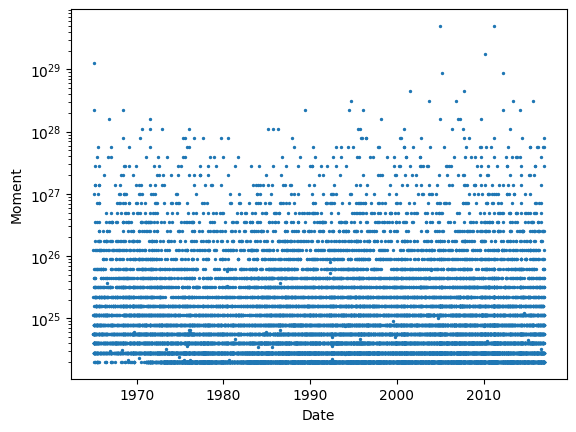

In [8]:
plt.scatter(df['Date'], df['Moment'], s = 2)
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Moment')
plt.show()

# Основная группа имеет порядок момента меньше 10^26, землетрясения с более высоким моментом большая редкость

In [9]:
# Выберем столбцы с числовыми значениями для последующего анализа, Date сохраним для интерпретации результатов кластеризации
df_numeric = df.loc[:, ['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Moment', 'Date']]

In [10]:
#Нормализуем данные при помощи MixMax масштабирования
from sklearn import preprocessing

minmax_processed = preprocessing.MinMaxScaler().fit_transform(df_numeric.drop('Date',axis=1))
df_numeric_scaled = pd.DataFrame(minmax_processed, index=df_numeric.index, columns=df_numeric.columns[:-1])
df_numeric_scaled.head()

,Latitude,Longitude,Depth,Magnitude,Moment
0,0.590649,0.904493,0.189274,0.138889,0.000018
1,0.484060,0.853759,0.115675,0.083333,0.000007
2,0.346451,0.016736,0.030096,0.194444,0.000041
3,0.110396,0.434562,0.022964,0.083333,0.000007
4,0.545838,0.851190,0.022964,0.083333,0.000007


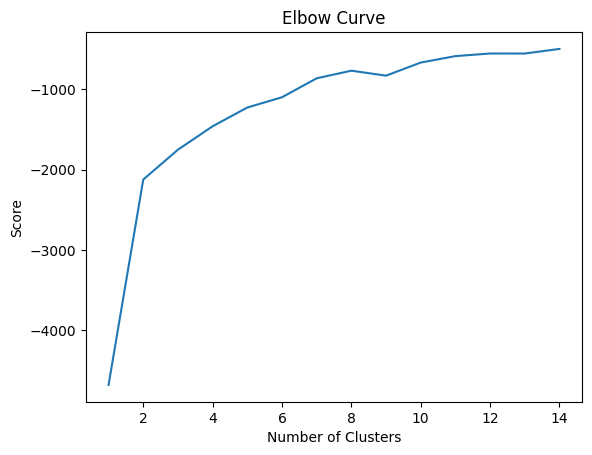

In [11]:
# Построим Elbow Curve, чтобы выбрать количество кластеров по месту перелома графика
Nc = range(1, 15)
kmeans = [KMeans(n_clusters=i, n_init='auto') for i in Nc]
score = [kmeans[i].fit(df_numeric_scaled).score(df_numeric_scaled) for i in range(len(kmeans))]

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [12]:
# Выбрали количество кластеров = 2
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(df_numeric_scaled)
df_numeric['cluster'] = kmeans.labels_
df_numeric.head()

,Latitude,Longitude,Depth,Magnitude,Moment,Date,cluster
0,19.246,145.616,131.6,6.0,1.122018e+25,1965-01-02,1
1,1.863,127.352,80.0,5.8,5.623413e+24,1965-01-04,1
2,-20.579,-173.972,20.0,6.2,2.238721e+25,1965-01-05,0
3,-59.076,-23.557,15.0,5.8,5.623413e+24,1965-01-08,0
4,11.938,126.427,15.0,5.8,5.623413e+24,1965-01-09,1


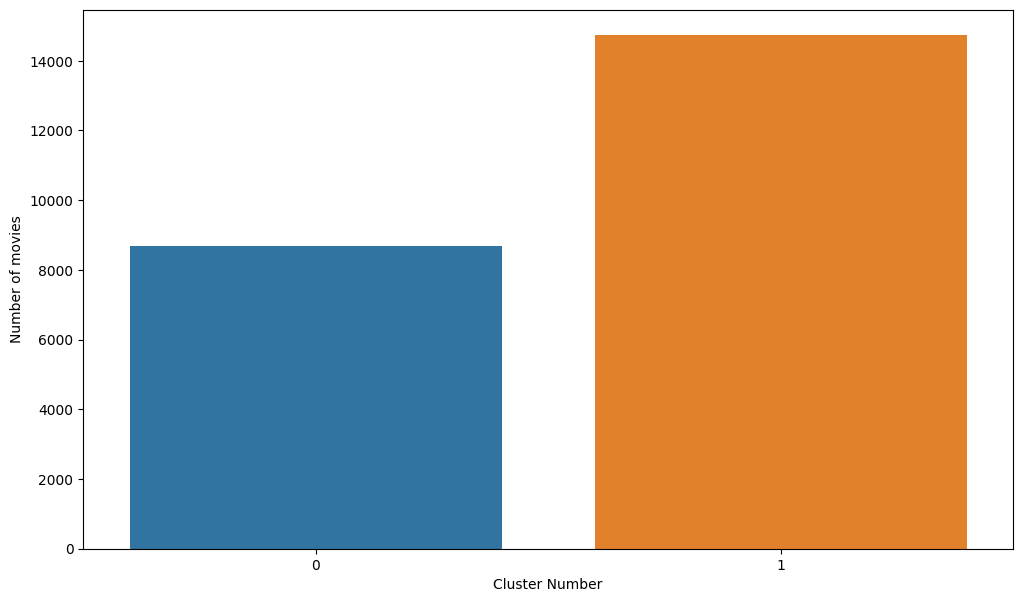

In [13]:
# Построим график распределения землетрясений по кластерам
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,2,1),y=df_numeric.groupby(['cluster']).count()['Date'].values)
x=axis.set_xlabel("Cluster Number")
x=axis.set_ylabel("Number of movies")

In [14]:
# Выведем средние значения по каждому кластеру
df_numeric.groupby(['cluster']).mean()

,Latitude,Longitude,Depth,Magnitude,Moment
cluster,,,,,
0,-9.909468,-113.255801,80.643273,5.864487,1.019463e+26
1,8.509115,129.754869,64.916349,5.893210,1.819436e+26


In [15]:
# Выведем размеры кластеров
size_array = list(df_numeric.groupby(['cluster']).count()['Date'].values)
size_array

[8681, 14728]

In [16]:
# Пример данных первого кластера
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[0])].sample(5)

,Latitude,Longitude,Depth,Magnitude,Moment,Date,cluster
16159,-54.471,5.742,10.0,5.7,3.981072e+24,2003-02-14,0
7307,20.357,-115.765,10.0,6.4,4.466836e+25,1984-12-02,0
20768,-25.192,-177.552,184.7,5.6,2.818383e+24,2011-05-05,0
18287,-7.006,-80.485,23.0,6.3,3.162278e+25,2007-02-24,0
16855,49.623,-126.967,23.7,6.4,4.466836e+25,2004-07-19,0


In [17]:
# Пример данных второго кластера
df_numeric[df_numeric['cluster']==size_array.index(sorted(size_array)[1])].sample(5)

,Latitude,Longitude,Depth,Magnitude,Moment,Date,cluster
6775,1.626,122.160,499.4,5.6,2.818383e+24,1983-10-26,1
16169,39.610,77.230,11.0,6.3,3.162278e+25,2003-02-24,1
3836,26.558,140.275,548.0,5.5,1.995262e+24,1976-02-14,1
20333,11.865,43.716,10.0,5.5,1.995262e+24,2010-11-14,1
4506,-9.965,117.327,33.0,5.7,3.981072e+24,1977-10-07,1


In [18]:
# После добавления столбца с моментом землетрясения хорошо заметно, что энергия, выделяемая землетрясениями
# с высокой магнитудой (8 - 9), на несколько порядков выше, чем с меньшей магнитудой (5.5 - 6)

# В первом кластере точка средних значений находится в районе столкновения Тихоокенаской литосферной плиты с плитой Наска
# Землетрясения этой группы имеют более высокую глубину и меньший момент

# Во втором кластере точка средних значений находится в районе столкновения Филиппинской литосферной плиты с другими плитами
# Эти землетрясения имеют меньшую глубину, но при этом больший момент и соответственно большую магнитуду

# Основное деление землетрясений по группам произошло на основании их долготы
# Первый кластер в основном содержит значения с отрицательной (западной) долготой
# Второй кластер в основном содержит значения с положительной (восточной) долготой

# Намного больше землетрясений происходит в восточном полушарии (14728), в западном их почти в два раза меньше (8681)